# Part III - Feature Engineering and Modelling for Clustering Project

---

1. Import packages
2. Load data
3. Feature Engineering
4. Find the Optimal Number of Clusters
5. Model Training
6. CLuster Interpretation

---

## 1. Import packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.outliers import Winsorizer
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.cm as cm
from scipy.sparse import hstack
import umap.umap_ as umap

---
## 2. Load data

In [27]:
df = pd.read_csv("data_for_modelling.csv", index_col=False, parse_dates=['date'])

In [28]:
df.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77692 entries, 0 to 77691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                77692 non-null  datetime64[ns]
 1   status              77692 non-null  object        
 2   fulfilment          77692 non-null  object        
 3   sales_channel       77692 non-null  object        
 4   ship_service_level  77692 non-null  object        
 5   category            77692 non-null  object        
 6   size                77692 non-null  object        
 7   amazon_standard_id  77692 non-null  object        
 8   qty                 77692 non-null  int64         
 9   currency            77692 non-null  object        
 10  sales               77692 non-null  float64       
 11  clean_ship_state    77692 non-null  object        
 12  promotion_used      77692 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int

---

## 3. Feature engineering

In this section, several preprocessing steps will be performed to prepare the data for modeling. The objective of clustering is to group customers based on their behavior. Therefore, the first step is to aggregate the data at the customer level, rather than at the transaction level.

### Per Customer

In [30]:
# feature engineering per customer
df['promo_used'] = df['promotion_used'].astype(int)

agg_df = df.groupby('amazon_standard_id').agg({
    'qty': ['sum', 'mean'],
    'sales': ['sum', 'mean'],
    'promotion_used': 'mean',
    'category': lambda x: x.mode()[0],
    'size': lambda x: x.mode()[0],
    'clean_ship_state': lambda x: x.mode()[0],
    'date' : ['min', 'max', 'count']
})

agg_df.columns = [
    'total_qty', 'avg_qty_per_order',
    'total_sales', 'avg_sales_per_order',
    'promo_used_ratio',
    'freq_category',
    'freq_size',
    'freq_ship_state',
    'last_order_date', 'first_order_date', 'total_transactions'
]

agg_df = agg_df.reset_index()

# Recency Feature
agg_df['last_order_date'] = pd.to_datetime(agg_df['last_order_date'])
agg_df['recency_days'] = (df['date'].max() - agg_df['last_order_date']).dt.days

In [31]:
agg_df

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days
0,B01LYC0N7Q,3,1.0,1230.0,410.000000,0.333333,kurta,XL,Delhi,2022-04-02,2022-06-25,3,88
1,B01LYC0NV1,10,1.0,2986.0,298.600000,0.700000,kurta,XL,Tamil Nadu,2022-04-06,2022-06-15,10,84
2,B01LZMXYSV,5,1.0,1499.0,299.800000,0.800000,kurta,S,Karnataka,2022-04-08,2022-06-24,5,82
3,B01LZYQ93J,4,1.0,1204.0,301.000000,0.750000,kurta,M,Tamil Nadu,2022-06-04,2022-06-23,4,25
4,B01M0LXTZE,7,1.0,2644.0,377.714286,0.857143,kurta,M,Karnataka,2022-04-14,2022-05-09,7,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6542,B0B3X1PX3P,2,1.0,2476.0,1238.000000,1.000000,Set,M,Bihar,2022-06-24,2022-06-27,2,5
6543,B0B3X1ZSZP,3,1.5,2313.0,1156.500000,1.000000,Set,3XL,Andhra Pradesh,2022-06-24,2022-06-26,2,5
6544,B0B3X2392D,1,1.0,1238.0,1238.000000,1.000000,Set,XXL,Assam,2022-06-24,2022-06-24,1,5
6545,B0B3X2WPTW,2,1.0,2485.0,1242.500000,1.000000,Set,XXL,Jharkhand,2022-06-23,2022-06-25,2,6


### Handle Outlier

In [32]:
listItem = []

for col in agg_df.columns.drop(['amazon_standard_id', 'last_order_date', 'first_order_date', 'freq_category', 'freq_size', 'freq_ship_state']):
  listItem.append([col, round(agg_df[col].skew(),1), np.where(
    (round(agg_df[col].skew(),1) <= 0.5) & (round(agg_df[col].skew(),1) >= -0.5),
    'normal',
    np.where(
    (round(agg_df[col].skew(),1) < -1) | (round(agg_df[col].skew(),1) > 1),
    'highly skewed',
    'moderately skewed'))])

skewness = pd.DataFrame(columns=['column name', 'skewness', 'distribution'], data= listItem)
skewness

,column name,skewness,distribution
0,total_qty,6.5,highly skewed
1,avg_qty_per_order,46.4,highly skewed
2,total_sales,8.7,highly skewed
3,avg_sales_per_order,1.1,highly skewed
4,promo_used_ratio,-0.5,normal
5,total_transactions,6.5,highly skewed
6,recency_days,-1.4,highly skewed


Most of the columns are highly skewed, with `avg_qty_per_order` being the most skewed feature.

In [33]:
# Get upper, lower boundaries and percentage of outliers

column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['column name'][row]
  #checking upper and lower boundary
  if skewness['distribution'][row] == 'highly skewed': #pada highly skewed, konstanta yg digunakan adalah 3
    IQR = agg_df[col].quantile(0.75) - agg_df[col].quantile(0.25)
    lower_boundary = agg_df[col].quantile(0.25) - (IQR * 3)
    upper_boundary = agg_df[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = agg_df[col].mean() - 3* agg_df[col].std()
    upper_boundary = agg_df[col].mean() + 3* agg_df[col].std()
  #append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(agg_df[agg_df[col] > upper_boundary]) / len(agg_df) * 100) + (len(agg_df[agg_df[col] < lower_boundary]) / len(agg_df) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    #round the value
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,total_qty,42.00,-28.00,5.38
1,avg_qty_per_order,1.00,1.00,3.18
2,total_sales,26148.00,-17626.50,6.37
3,avg_sales_per_order,1774.74,-577.29,0.03
4,promo_used_ratio,1.54,-0.26,0.00
5,total_transactions,40.00,-26.50,5.68
6,recency_days,161.00,-14.00,0.00


Only four features have a high percentage of outliers (using a 1% threshold based on professional judgment). Since we do not want to apply robust capping but still need to perform capping as the model will be sensitive to extreme values, we use the quantile method with a small fold to handle the outliers.

In [34]:
# select feature with high percentage of outlier --> total outlier >1%
feature = ['total_qty', 'avg_qty_per_order', 'total_sales', 'total_transactions']

# Capping
winsoriser = Winsorizer(capping_method='quantiles',
                            tail='both',
                            fold=0.01,
                            variables=feature,
                            missing_values='ignore')

agg_df = winsoriser.fit_transform(agg_df)

### Scaling Numeric Features

In [35]:
# define cols
num_cols = ['total_qty', 'avg_qty_per_order', 'total_sales', 'avg_sales_per_order',
            'promo_used_ratio', 'total_transactions', 'recency_days'] # numerical columns
cat_cols = ['freq_category', 'freq_size', 'freq_ship_state']  # categorical columns
X = agg_df[cat_cols + num_cols].copy()

# Convert cat_cols to string (K-Prototypes needs str for cat vars)
for col in cat_cols:
    X[col] = X[col].astype(str)

# Scaling numeric
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

---

## 4. Find the optimal number of clusters

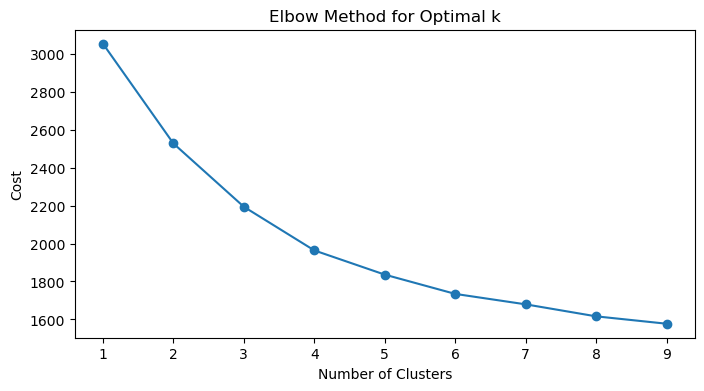

In [36]:
cost = []
K = range(1, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, random_state=42, init='Cao')
    clusters = kproto.fit_predict(X, categorical=[0, 1, 2])
    cost.append(kproto.cost_)

# Plot elbow
plt.figure(figsize=(8,4))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

From cluster 1 to 2, the cost decreases significantly, and there is still a noticeable drop from cluster 2 to 3. However, from cluster 3 to 4, the curve begins to flatten, indicating that additional clusters do not provide substantial improvement. Therefore, the optimal number of clusters is 3.

---

## 5. Model Training

In [37]:
optimal_k = 3

kproto = KPrototypes(n_clusters=optimal_k, random_state=42, init='Cao')
clusters = kproto.fit_predict(X, categorical=[0, 1, 2])

c:\Users\Legion\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Legion\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


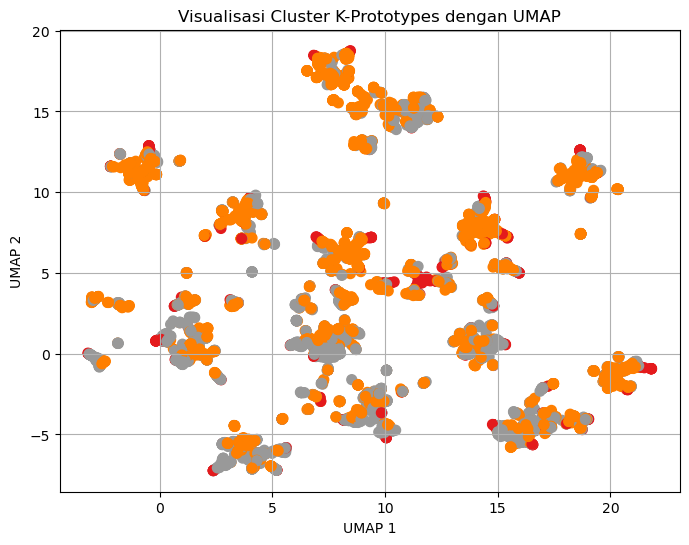

In [38]:
# --- OneHotEncoder after K-Prototypes ---
ohe = OneHotEncoder(sparse_output=False)
cat_encoded = ohe.fit_transform(X[cat_cols])

# --- Numerikal (MinMaxScaler udah dipakai sebelumnya)
num_scaled = X[num_cols].values

# --- Gabung
X_encoded = np.hstack([cat_encoded, num_scaled])

# --- UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = umap_model.fit_transform(X_encoded)

# --- Plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap='Set1', s=50)
plt.title('Visualisasi Cluster K-Prototypes dengan UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


---

## 6. Cluster Interpretation

In [39]:
# Assign cluster to agg_df
agg_df['cluster'] = clusters

In [40]:
agg_df[agg_df['cluster']==0].describe().T

,count,mean,min,25%,50%,75%,max,std
total_qty,427.0,69.466042,25.0,43.5,61.0,93.5,121.0,30.810425
avg_qty_per_order,427.0,1.00404,1.0,1.0,1.0,1.0,1.075,0.009577
total_sales,427.0,46416.467588,18746.0,30149.0,40921.0,59910.5,79407.26,19381.432963
avg_sales_per_order,427.0,733.979671,303.116883,515.928458,689.323529,870.64127,1499.764706,277.389542
promo_used_ratio,427.0,0.596141,0.169231,0.478889,0.580645,0.715933,0.967742,0.164288
last_order_date,427,2022-04-04 01:04:04.496487168,2022-03-31 00:00:00,2022-04-01 00:00:00,2022-04-02 00:00:00,2022-04-04 00:00:00,2022-06-06 00:00:00,NaN
first_order_date,427,2022-06-22 10:34:00.281030400,2022-05-07 00:00:00,2022-06-21 00:00:00,2022-06-26 00:00:00,2022-06-28 00:00:00,2022-06-29 00:00:00,NaN
total_transactions,427.0,69.11007,25.0,43.5,61.0,93.0,120.0,30.554877
recency_days,427.0,85.955504,23.0,86.0,88.0,89.0,90.0,8.184515
cluster,427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
agg_df[agg_df['cluster']==1].describe().T

,count,mean,min,25%,50%,75%,max,std
total_qty,3109.0,5.99807,1.0,2.0,4.0,8.0,39.0,6.352575
avg_qty_per_order,3109.0,1.001047,1.0,1.0,1.0,1.0,1.083333,0.008937
total_sales,3109.0,4698.936796,301.0,998.0,2456.0,5889.0,39846.0,5670.772967
avg_sales_per_order,3109.0,718.52617,229.0,528.666667,665.0,871.5,1985.0,275.821351
promo_used_ratio,3109.0,0.880193,0.333333,0.75,1.0,1.0,1.0,0.153566
last_order_date,3109,2022-04-24 11:29:39.736249600,2022-03-31 00:00:00,2022-04-05 00:00:00,2022-04-14 00:00:00,2022-05-07 00:00:00,2022-06-29 00:00:00,NaN
first_order_date,3109,2022-05-29 19:29:02.682534656,2022-03-31 00:00:00,2022-05-04 00:00:00,2022-06-12 00:00:00,2022-06-22 00:00:00,2022-06-29 00:00:00,NaN
total_transactions,3109.0,5.982309,1.0,2.0,4.0,8.0,39.0,6.341068
recency_days,3109.0,65.521068,0.0,53.0,76.0,85.0,90.0,25.056756
cluster,3109.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [42]:
agg_df[agg_df['cluster']==2].describe().T

,count,mean,min,25%,50%,75%,max,std
total_qty,3011.0,8.592826,1.0,2.0,6.0,11.0,58.0,8.761036
avg_qty_per_order,3011.0,1.001509,1.0,1.0,1.0,1.0,1.083333,0.010481
total_sales,3011.0,4575.244603,301.0,1133.0,2566.0,6017.5,30136.0,5070.654255
avg_sales_per_order,3011.0,517.525534,199.0,371.2,474.0,603.1,1640.909091,203.332213
promo_used_ratio,3011.0,0.397164,0.0,0.28,0.466667,0.538462,0.869565,0.222039
last_order_date,3011,2022-04-17 15:34:58.306210560,2022-03-31 00:00:00,2022-04-04 00:00:00,2022-04-09 00:00:00,2022-04-24 00:00:00,2022-06-29 00:00:00,NaN
first_order_date,3011,2022-06-02 08:24:32.999003648,2022-04-01 00:00:00,2022-05-14 00:00:00,2022-06-14 00:00:00,2022-06-24 00:00:00,2022-06-29 00:00:00,NaN
total_transactions,3011.0,8.556294,1.0,2.0,6.0,11.0,58.0,8.722012
recency_days,3011.0,72.350714,0.0,66.0,81.0,86.0,90.0,19.84548
cluster,3011.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0


### How many customers are there in each clusters?

[Text(0, 0, '3,109'), Text(0, 0, '3,011'), Text(0, 0, '427')]

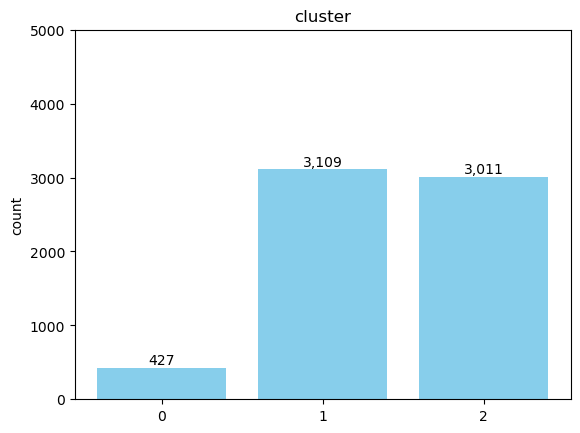

In [43]:
# Count of customer per cluster
cust_per_cluster = agg_df['cluster'].value_counts()

fig, ax = plt.subplots()
bar_container = ax.bar(cust_per_cluster.index, cust_per_cluster.values, color='skyblue')
ax.set(ylabel='count', title='cluster', ylim=(0, 5000), xticks=[0,1,2])
ax.bar_label(bar_container, fmt='{:,.0f}')

Based on the bar chart above, Cluster 0 is the smallest group with 427 customers, while Cluster 1 is the biggest group followed by Cluster 2.

### How much total sales per cluster?

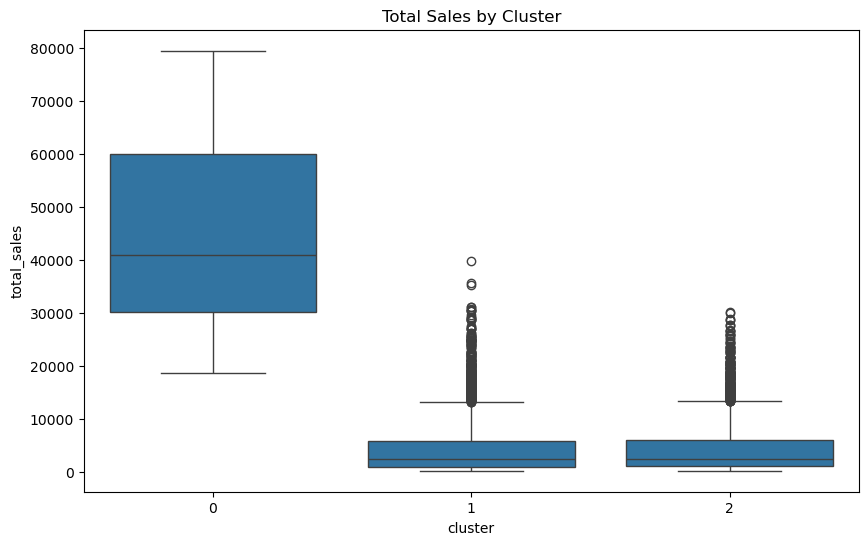

In [44]:
# total_sales by cluster
plt.figure(figsize=(10,6))
sns.boxplot(x='cluster', y='total_sales', data=agg_df)
plt.title('Total Sales by Cluster')
plt.show()

From the boxplot above, we can conclude that Cluster 0 consists of customers who spend the most, with maximum sales about 80,000 INR. Cluster 1 can be categorized as medium to high spenders, with maximum sales above 40,000 INR. In contrast, Cluster 2 represents the customers who spend the least.

### What're the top 5 of category per cluster?

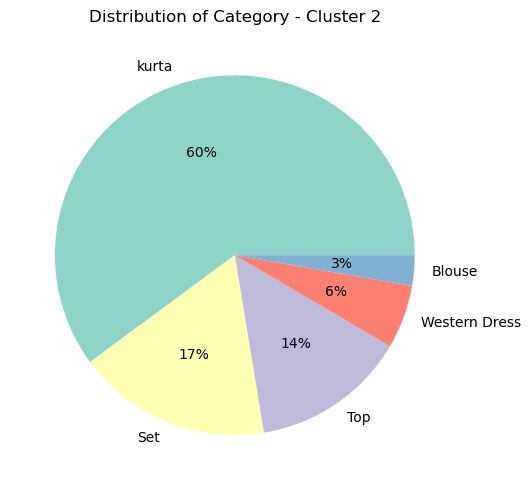

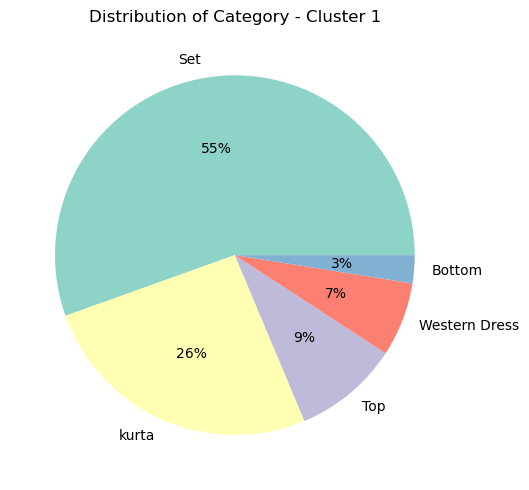

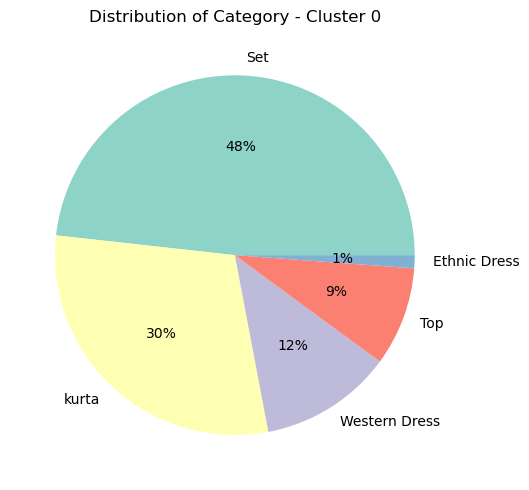

In [45]:
# Get unique value from cluster column
clusters = agg_df['cluster'].unique()

# Loop per cluster
for cl in clusters:
    # Filter data per cluster
    data_pie = agg_df[agg_df['cluster'] == cl]['freq_category'].value_counts().head(5)
    
    # Plot pie chart
    fig = plt.figure(figsize=(7, 5))
    plt.pie(
        data_pie,
        labels=data_pie.index,
        autopct='%.0f%%',
        colors=plt.cm.Set3.colors
    )
    plt.title(f'Distribution of Category - Cluster {cl}')
    plt.tight_layout()
    plt.show()


The most preferred category in both Cluster 0 and Cluster 1 is `set`, followed by `kurta`. In contrast, customers in Cluster 2 prefer `kurta` over `set`. The top four categories across all clusters are quite similar: `kurta`, `set`, `top`, and `western dress`. However, the 5th most popular category differs accross clusters.

### How is Distribution of Clusters by Shipping Location (Ship State)?

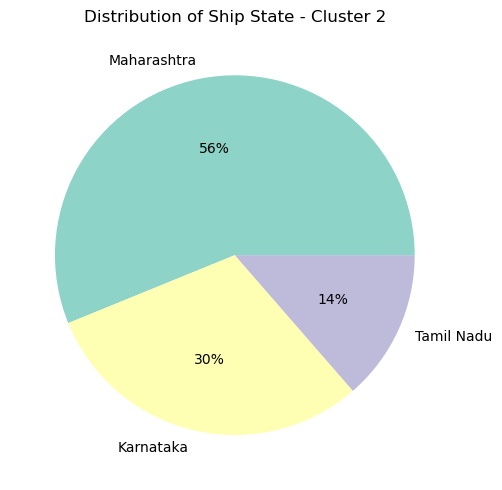

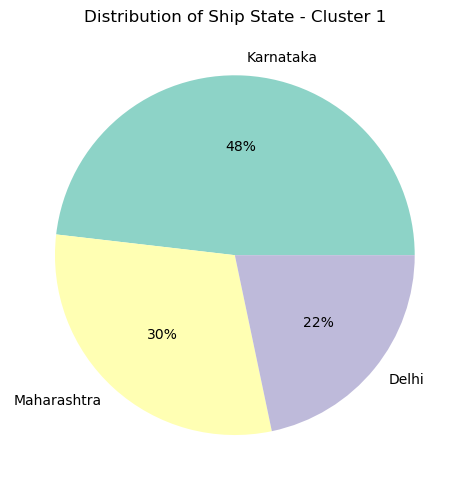

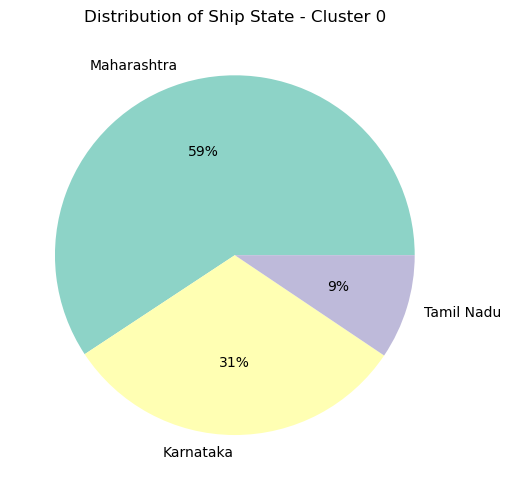

In [46]:
# Get unique value from cluster column
clusters = agg_df['cluster'].unique()

# Loop per cluster
for cl in clusters:
    # Filter data per cluster
    data_pie = agg_df[agg_df['cluster'] == cl]['freq_ship_state'].value_counts().head(3)
    
    # Plot pie chart
    fig = plt.figure(figsize=(7, 5))
    plt.pie(
        data_pie,
        labels=data_pie.index,
        autopct='%.0f%%',
        colors=plt.cm.Set3.colors
    )
    plt.title(f'Distribution of Ship State - Cluster {cl}')
    plt.tight_layout()
    plt.show()


Clusters 2 and 0 mostly ship to Maharashtra and Karnataka. Interestingly, the third most common shipping destination is the same for Cluster 0 and Cluster 2: Tamil Nadu, while for Cluster 1, the third is Delhi. On the other hand, Cluster 1 has a different order of top destinations, with Karnataka coming first, followed by Maharashtra.

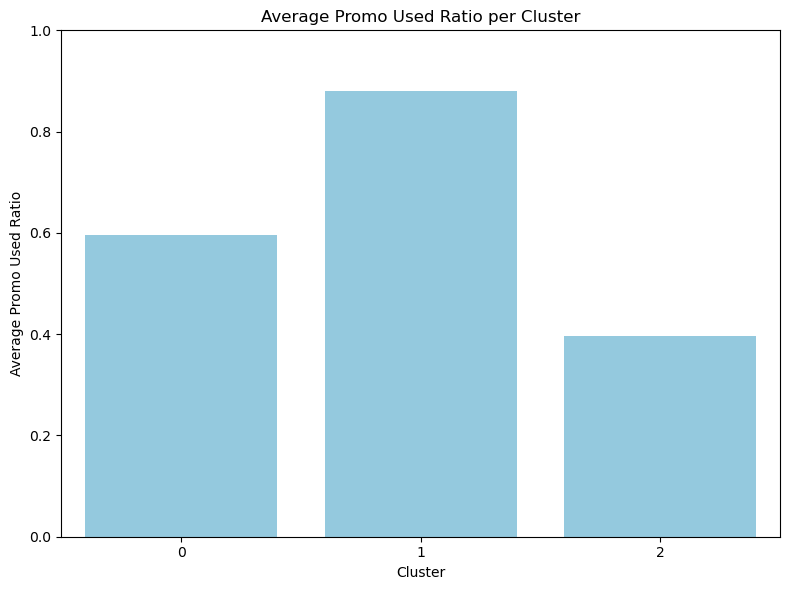

In [47]:
# Count average of promo_used_ratio per cluster
df_ratio = agg_df.groupby('cluster')['promo_used_ratio'].mean().reset_index()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=df_ratio, x='cluster', y='promo_used_ratio', color='skyblue')

plt.title('Average Promo Used Ratio per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Promo Used Ratio')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Cluster 0, which represents the big spenders, has a medium rate of promo usage, meaning this cluster can be categorized as `royal customers`. In contrast, although Cluster 1 also shows high spending, these customers seem to rely heavily on promos, they can be categorized as `opportunistic customers`. Meanwhile, Cluster 2, which consists of lower spenders, shows a low promo usage rate and could be categorized as `passive customers`.

## Save data for Dashboard

In [48]:
agg_df.to_csv("data_for_tableau.csv")